# DS-GA 1016 Final Project

## Import libraries

In [4]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten
from sklearn.model_selection import KFold
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from itertools import zip_longest

## Read data
*Bahrami, Bahador, and Joaquin Navajas. “4 Arm Bandit Task Dataset.” OSF, 8 Feb. 2022. Web.*

In [5]:
""" 
id: subject id
choice: 1, 2, 3, 4
reward: reward of the choice, according to predefined reward structure
payoff_group: 2, 3, 4, three types of reward structures
reward_c1, reward_c2, reward_c3, reward_c4: reward of each choice in the current trial, according to hte predefined reward structure
"""
data = pd.read_csv("DataAllSubjectsRewards.csv").drop(columns=['rt', 'reward_c1', 'reward_c2', 'reward_c3', 'reward_c4'])

In [6]:
data.head()

,id,choice,reward,payoff_group
0,1,1,84,2
1,1,2,90,2
2,1,3,53,2
3,1,4,24,2
4,1,2,92,2


## Preprocessing
1. split data by `payoff_group`
2. For each group, do train/val/test split
3. For each train/val/test in each payoff group, create sequences of data using sliding windows

In [7]:
# Remove NaN values
# Split data according to payoff groups
payoff_group_2 = data[data['payoff_group'] == 2].dropna()
payoff_group_3 = data[data['payoff_group'] == 3].dropna()
payoff_group_4 = data[data['payoff_group'] == 4].dropna()

In [8]:
def train_val_test_split(payoff_group):
    """ 
    Input:
        payoff_group: pd.DataFrame
    Output:
        data_train: pd.DataFrame
        data_val: pd.DataFrame
        data_test: pd.DataFrame
    For each payoff_group, split 20% of users as test set, 20% as validation set, and 60% as training set.
    """
    max_id = payoff_group['id'].max()
    min_id = payoff_group['id'].min()
    test_percent = 0.2
    
    split_index = int((max_id - min_id + 1) * (1 - test_percent)) + min_id    
    
    data_test = payoff_group[payoff_group['id'] >= split_index]
    data_train_val = payoff_group[payoff_group['id'] < split_index]
    
    data_test = data_test.drop(columns=['payoff_group'])
    data_train_val = data_train_val.drop(columns=['id','payoff_group'])
    
    return data_train_val, data_test

In [9]:
payoff_2_train_val, payoff_2_test = train_val_test_split(payoff_group_2)
payoff_3_train_val, payoff_3_test = train_val_test_split(payoff_group_3)
payoff_4_train_val, payoff_4_test = train_val_test_split(payoff_group_4)

In [10]:
# Create sliding windows
def sliding_window(df):
    window_size = 5
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    num_windows = num_rows - window_size + 1
    ndarray = np.empty((num_windows, window_size, num_cols), dtype=df.values.dtype)
    for i in range(num_windows):
        ndarray[i] = df.iloc[i:i+window_size].values
    return ndarray

seq_2_train_val = sliding_window(payoff_2_train_val)
seq_3_train_val = sliding_window(payoff_3_train_val)
seq_4_train_val = sliding_window(payoff_4_train_val)

In [11]:
seq_2_test_user_id = payoff_2_test['id'].unique()
seq_3_test_user_id = payoff_3_test['id'].unique()
seq_4_test_user_id = payoff_4_test['id'].unique()

In [15]:
print(seq_4_test_user_id)

[901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918
 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936
 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954
 955 956 957 958 959 960 961 962 963 964 965]


In [16]:
# split each train, val, test set into X and y
def X_y_split_train_val(seq):
    
    # initialize empty arrays for X_train and y_train
    X_train = np.zeros((len(seq), 4, 2))
    y_train = np.zeros((len(seq), 4))

    # loop through each example in the data
    for i, example in enumerate(seq):
        # extract the first four choice-reward pairs as X_train
        X_train[i] = np.array(example[:4])
        # extract the fifth choice from the last step as y_train
        y_train[i][example[4][0]-1] = 1

    return X_train, y_train

In [17]:
seq_2_train_X, seq_2_train_y = X_y_split_train_val(seq_2_train_val)
seq_3_train_X, seq_3_train_y = X_y_split_train_val(seq_3_train_val)
seq_4_train_X, seq_4_train_y = X_y_split_train_val(seq_4_train_val)

## NN model for payoff structure 2

In [18]:
# Define the LSTM model
def create_model(units=64, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(4, 2), return_sequences=True))
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.99)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Generate some training data
X_train = seq_2_train_X
y_train = seq_2_train_y

# Train the model on the best set of parameters
model = create_model(units=64, learning_rate=0.001)
model.fit(X_train, y_train, epochs=300, batch_size=2048)



# # Define the cross-validation method
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Define the parameter search space
# param_grid = {
#     'batch_size': [2, 4, 8],
#     'epochs': [5, 10, 15],
#     'units': [32, 64, 128],
#     'dropout': [0.1, 0.2, 0.3],
#     'learning_rate': [0.001, 0.01, 0.1]
# }

# best_score = float('-inf')
# best_params = {}

# # Perform cross-validation and parameter search
# for batch_size in param_grid['batch_size']:
#     for epochs in param_grid['epochs']:
#         for units in param_grid['units']:
#             for dropout in param_grid['dropout']:
#                 for learning_rate in param_grid['learning_rate']:
#                     print(f'Training with batch size={batch_size}, epochs={epochs}, units={units}, dropout={dropout}, learning_rate={learning_rate}')
#                     cv_scores = []
#                     for train_idx, val_idx in kf.split(X_train):
#                         model = None  # Clearing the NN
#                         model = create_model(units=units, dropout=dropout, learning_rate=learning_rate)  # Create a new model instance
#                         X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
#                         y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
#                         es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=0, restore_best_weights=True)
#                         model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, validation_data=(X_val_fold, y_val_fold), verbose=0, callbacks=[es])
#                         score = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]
#                         cv_scores.append(score)
#                     mean_score = sum(cv_scores) / len(cv_scores)
#                     print(f'Mean score: {mean_score:.4f}\n')
#                     if mean_score > best_score:
#                         best_score = mean_score
#                         best_params = {'batch_size': batch_size, 'epochs': epochs, 'units': units, 'dropout': dropout, 'learning_rate': learning_rate}

# print(f'Best mean score: {best_score:.4f}')
# print(f'Best params: {best_params}\n')

Epoch 1/300


2023-05-07 23:09:44.120657: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


19/19 [==============================] - 1s 17ms/step - loss: 1.3064 - accuracy: 0.3345
Epoch 2/300
19/19 [==============================] - 0s 16ms/step - loss: 1.2535 - accuracy: 0.3352
Epoch 3/300
19/19 [==============================] - 0s 16ms/step - loss: 1.2330 - accuracy: 0.4082
Epoch 4/300
19/19 [==============================] - 0s 16ms/step - loss: 1.2135 - accuracy: 0.4510
Epoch 5/300
19/19 [==============================] - 0s 16ms/step - loss: 1.1825 - accuracy: 0.4886
Epoch 6/300
19/19 [==============================] - 0s 16ms/step - loss: 1.1294 - accuracy: 0.5259
Epoch 7/300
19/19 [==============================] - 0s 15ms/step - loss: 1.0914 - accuracy: 0.5478
Epoch 8/300
19/19 [==============================] - 0s 16ms/step - loss: 1.0743 - accuracy: 0.5570
Epoch 9/300
19/19 [==============================] - 0s 16ms/step - loss: 1.0626 - accuracy: 0.5619
Epoch 10/300
19/19 [==============================] - 0s 19ms/step - loss: 1.0532 - accuracy: 0.5661
Epoch 11/30

In [84]:
# id = seq_2_test_user_id[0]
# id_data = payoff_2_test[payoff_2_test['id'] == id]
# id_data = id_data[["choice", "reward"]]
# seq_2_id_test = sliding_window(id_data)
# print(seq_2_id_test.shape)

# seq_id_test_X, seq_id_test_y = X_y_split_train_val(seq_2_id_test)
# print(seq_id_test_X.shape)
# print(seq_id_test_y.shape)

# X_test = seq_id_test_X
# y_pred = model.predict(X_test)
# y_true = seq_id_test_y

# y_pred_labels = list(np.argmax(y_pred, axis=1))
# print(f"y_pred_labels: {len(y_pred_labels)}")
# y_true_labels = list(np.argmax(y_true, axis=1))

# id_result = []

# for i in range(len(y_pred_labels)):
#     id_result.append(1 if y_pred_labels[i] == y_true_labels[i] else 0)
    
# print(len(id_result))

In [26]:
seq_2_total_result = []
seq_2_total_result_ = []

for id in seq_2_test_user_id:
    # select this id's data from payoff_2_test(DF)
    id_data = payoff_2_test[payoff_2_test['id'] == id]
    id_data = id_data[["choice", "reward"]]  # remove id column
    print(id_data.shape)
    seq_2_id_test = sliding_window(id_data)

    seq_id_test_X, seq_id_test_y = X_y_split_train_val(seq_2_id_test)

    X_test = seq_id_test_X
    y_pred = model.predict(X_test)
    y_true = seq_id_test_y

    y_pred_labels = list(np.argmax(y_pred, axis=1))
    y_true_labels = list(np.argmax(y_true, axis=1))

    id_result = []

    for i in range(len(y_pred_labels)):
        id_result.append(1 if y_pred_labels[i] == y_true_labels[i] else 0)
    
    seq_2_total_result.append(id_result)
    seq_2_total_result_.append(y_pred_labels)

(143, 2)
5/5 [==============================] - 0s 2ms/step
(149, 2)
5/5 [==============================] - 0s 714us/step
(148, 2)
5/5 [==============================] - 0s 771us/step
(147, 2)
5/5 [==============================] - 0s 803us/step
(148, 2)
5/5 [==============================] - 0s 1ms/step
(142, 2)
5/5 [==============================] - 0s 1ms/step
(135, 2)
5/5 [==============================] - 0s 2ms/step
(149, 2)
5/5 [==============================] - 0s 786us/step
(149, 2)
5/5 [==============================] - 0s 1ms/step
(142, 2)
5/5 [==============================] - 0s 683us/step
(146, 2)
5/5 [==============================] - 0s 630us/step
(139, 2)
5/5 [==============================] - 0s 682us/step
(144, 2)
5/5 [==============================] - 0s 688us/step
(138, 2)
5/5 [==============================] - 0s 762us/step
(143, 2)
5/5 [==============================] - 0s 657us/step
(145, 2)
5/5 [==============================] - 0s 873us/step
(144, 2)
5/5 [====

In [27]:
print(seq_2_total_result_)

[[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2], [0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2], [0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 0, 0

In [28]:
seq_2_accuracy = []
for i in range(max(map(len, seq_2_total_result))):
    filtered_lists = [lst[i] for lst in seq_2_total_result if i < len(lst)]
    if filtered_lists:
        seq_2_accuracy.append(sum(filtered_lists) / len(filtered_lists))
    else:
        seq_2_accuracy.append(0)

print(seq_2_accuracy)

[0.4090909090909091, 0.5454545454545454, 0.3939393939393939, 0.4393939393939394, 0.5303030303030303, 0.48484848484848486, 0.6060606060606061, 0.5757575757575758, 0.6060606060606061, 0.6363636363636364, 0.7121212121212122, 0.5757575757575758, 0.6363636363636364, 0.6666666666666666, 0.6363636363636364, 0.6060606060606061, 0.6515151515151515, 0.6212121212121212, 0.5454545454545454, 0.6515151515151515, 0.6212121212121212, 0.6818181818181818, 0.696969696969697, 0.5757575757575758, 0.5757575757575758, 0.6212121212121212, 0.3939393939393939, 0.4393939393939394, 0.36363636363636365, 0.48484848484848486, 0.5757575757575758, 0.5454545454545454, 0.6212121212121212, 0.5303030303030303, 0.5454545454545454, 0.5909090909090909, 0.6666666666666666, 0.6060606060606061, 0.42424242424242425, 0.5151515151515151, 0.45454545454545453, 0.5, 0.4393939393939394, 0.5303030303030303, 0.5909090909090909, 0.5303030303030303, 0.7424242424242424, 0.6515151515151515, 0.7727272727272727, 0.696969696969697, 0.651515151

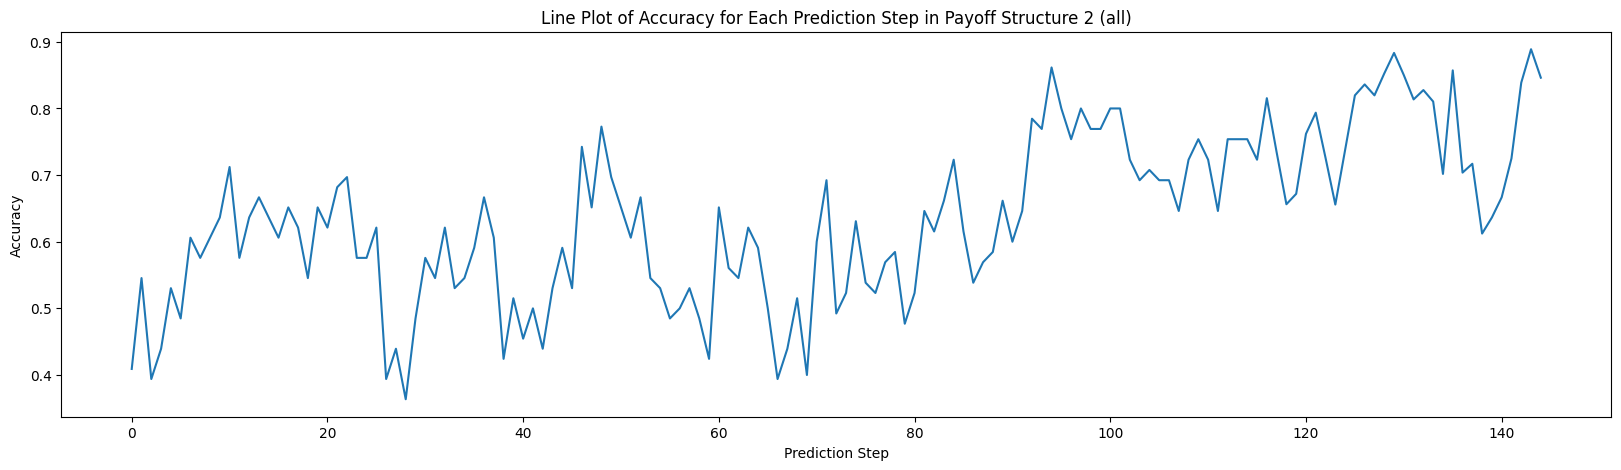

In [30]:
x_values = list(range(145))
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x_values, seq_2_accuracy)
ax.set_xlabel('Prediction Step')
ax.set_ylabel('Accuracy')
ax.set_title('Line Plot of Accuracy for Each Prediction Step in Payoff Structure 2 (all)')
# show the plot
plt.show()

In [31]:
unique_length = {}
for res in seq_2_total_result:
    if len(res) not in unique_length.keys():
        unique_length[len(res)] = 1
    else:
        unique_length[len(res)] += 1
print(unique_length)
invalid_result = []
for i, res in enumerate(seq_2_total_result):
    if len(res) == 120 or len(res) == 69 or len(res) == 129 or len(res) == 122 or len(res) == 117 or len(res) == 123:
        invalid_result.append(i)
print(invalid_result)

{139: 5, 145: 13, 144: 14, 143: 4, 138: 4, 131: 1, 142: 9, 135: 1, 140: 2, 134: 1, 141: 2, 120: 1, 137: 1, 69: 1, 129: 1, 136: 2, 122: 1, 132: 1, 117: 1, 123: 1}
[18, 22, 36, 54, 56, 60]


In [32]:
res_2_total_result_new = []
for i, res in enumerate(seq_2_total_result):
    if i not in invalid_result:
        res_2_total_result_new.append(res)
print(min([len(res) for res in res_2_total_result_new]))

131


In [33]:
# calculate accuracy for each prediction step across all users in payoff structure 2
def calculate_accuracy(list_of_lists):
    n = len(list_of_lists)
    accuracy_scores = []
    for i in range(min([len(res) for res in list_of_lists])):
        total = sum(lst[i] for lst in list_of_lists)
        accuracy = total / n
        accuracy_scores.append(accuracy)
    return accuracy_scores

In [34]:
seq_2_accuracy = calculate_accuracy(res_2_total_result_new)
print(seq_2_accuracy)

[0.4, 0.5666666666666667, 0.4, 0.43333333333333335, 0.5166666666666667, 0.5333333333333333, 0.6333333333333333, 0.6166666666666667, 0.6333333333333333, 0.65, 0.7166666666666667, 0.6, 0.65, 0.6833333333333333, 0.6333333333333333, 0.6333333333333333, 0.65, 0.6333333333333333, 0.5666666666666667, 0.65, 0.6333333333333333, 0.6833333333333333, 0.6833333333333333, 0.5666666666666667, 0.5666666666666667, 0.6666666666666666, 0.4, 0.45, 0.35, 0.48333333333333334, 0.5666666666666667, 0.5333333333333333, 0.65, 0.5833333333333334, 0.5333333333333333, 0.5833333333333334, 0.7, 0.5833333333333334, 0.4166666666666667, 0.5, 0.43333333333333335, 0.5, 0.4166666666666667, 0.5166666666666667, 0.5833333333333334, 0.5166666666666667, 0.7333333333333333, 0.65, 0.7666666666666667, 0.6833333333333333, 0.6666666666666666, 0.6, 0.6666666666666666, 0.5666666666666667, 0.5333333333333333, 0.4666666666666667, 0.5, 0.5166666666666667, 0.5, 0.43333333333333335, 0.6833333333333333, 0.5666666666666667, 0.55, 0.616666666

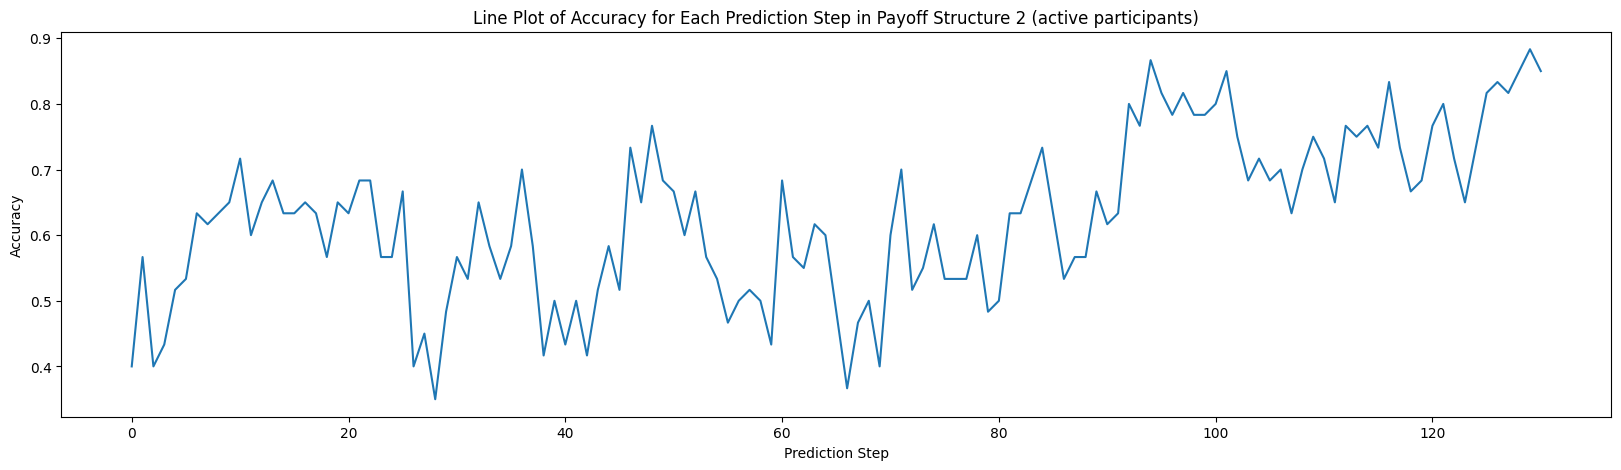

In [35]:
x_values = list(range(min([len(res) for res in res_2_total_result_new])))
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x_values, seq_2_accuracy)
ax.set_xlabel('Prediction Step')
ax.set_ylabel('Accuracy')
ax.set_title('Line Plot of Accuracy for Each Prediction Step in Payoff Structure 2 (active participants)')
# show the plot
plt.show()

## NN model for payoff structure 3

In [36]:
# Define the LSTM model
def create_model(units=64, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(4, 2), return_sequences=True))
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.99)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Generate some training data
X_train = seq_3_train_X
y_train = seq_3_train_y

# Train the model on the best set of parameters
model = create_model(units=64, learning_rate=0.001)
model.fit(X_train, y_train, epochs=300, batch_size=2048)

Epoch 1/300
18/18 [==============================] - 1s 13ms/step - loss: 1.2384 - accuracy: 0.4289
Epoch 2/300
18/18 [==============================] - 0s 14ms/step - loss: 1.1640 - accuracy: 0.4813
Epoch 3/300
18/18 [==============================] - 0s 15ms/step - loss: 1.1344 - accuracy: 0.4964
Epoch 4/300
18/18 [==============================] - 0s 16ms/step - loss: 1.1109 - accuracy: 0.5044
Epoch 5/300
18/18 [==============================] - 0s 15ms/step - loss: 1.0913 - accuracy: 0.5195
Epoch 6/300
18/18 [==============================] - 0s 15ms/step - loss: 1.0731 - accuracy: 0.5310
Epoch 7/300
18/18 [==============================] - 0s 15ms/step - loss: 1.0518 - accuracy: 0.5379
Epoch 8/300
18/18 [==============================] - 0s 15ms/step - loss: 1.0237 - accuracy: 0.5649
Epoch 9/300
18/18 [==============================] - 0s 16ms/step - loss: 0.9872 - accuracy: 0.6065
Epoch 10/300
18/18 [==============================] - 0s 16ms/step - loss: 0.9491 - accuracy: 0.6305

In [37]:
seq_3_total_result = []
seq_3_total_result_ = []

for id in seq_3_test_user_id:
    # select this id's data from payoff_2_test(DF)
    id_data = payoff_3_test[payoff_3_test['id'] == id]
    id_data = id_data[["choice", "reward"]]  # remove id column
    print(id_data.shape)
    seq_3_id_test = sliding_window(id_data)

    seq_id_test_X, seq_id_test_y = X_y_split_train_val(seq_3_id_test)

    X_test = seq_id_test_X
    y_pred = model.predict(X_test)
    y_true = seq_id_test_y

    y_pred_labels = list(np.argmax(y_pred, axis=1))
    y_true_labels = list(np.argmax(y_true, axis=1))

    id_result = []

    for i in range(len(y_pred_labels)):
        id_result.append(1 if y_pred_labels[i] == y_true_labels[i] else 0)
    
    seq_3_total_result.append(id_result)
    seq_3_total_result_.append(y_pred_labels)

print(seq_3_total_result_)

(147, 2)
5/5 [==============================] - 0s 1ms/step
(149, 2)
5/5 [==============================] - 0s 1ms/step
(146, 2)
5/5 [==============================] - 0s 871us/step
(148, 2)
5/5 [==============================] - 0s 849us/step
(147, 2)
5/5 [==============================] - 0s 842us/step
(149, 2)
5/5 [==============================] - 0s 734us/step
(146, 2)
5/5 [==============================] - 0s 713us/step
(149, 2)
5/5 [==============================] - 0s 789us/step
(148, 2)
5/5 [==============================] - 0s 643us/step
(144, 2)
5/5 [==============================] - 0s 691us/step
(148, 2)
5/5 [==============================] - 0s 691us/step
(148, 2)
5/5 [==============================] - 0s 718us/step
(148, 2)
5/5 [==============================] - 0s 899us/step
(149, 2)
5/5 [==============================] - 0s 1ms/step
(148, 2)
5/5 [==============================] - 0s 1ms/step
(139, 2)
5/5 [==============================] - 0s 1ms/step
(143, 2)
5/5 [====

In [38]:
seq_3_accuracy = []
for i in range(max(map(len, seq_3_total_result))):
    filtered_lists = [lst[i] for lst in seq_3_total_result if i < len(lst)]
    if filtered_lists:
        seq_3_accuracy.append(sum(filtered_lists) / len(filtered_lists))
    else:
        seq_3_accuracy.append(0)

print(seq_3_accuracy)

[0.5555555555555556, 0.5555555555555556, 0.47619047619047616, 0.6666666666666666, 0.5873015873015873, 0.6666666666666666, 0.5555555555555556, 0.6031746031746031, 0.6507936507936508, 0.6825396825396826, 0.6825396825396826, 0.5873015873015873, 0.6349206349206349, 0.5873015873015873, 0.6984126984126984, 0.5873015873015873, 0.6984126984126984, 0.5873015873015873, 0.746031746031746, 0.6666666666666666, 0.6507936507936508, 0.6190476190476191, 0.6507936507936508, 0.6190476190476191, 0.6666666666666666, 0.6349206349206349, 0.6507936507936508, 0.6825396825396826, 0.6507936507936508, 0.746031746031746, 0.5714285714285714, 0.7142857142857143, 0.6031746031746031, 0.6349206349206349, 0.5555555555555556, 0.5238095238095238, 0.5396825396825397, 0.6031746031746031, 0.6349206349206349, 0.7142857142857143, 0.6349206349206349, 0.6825396825396826, 0.7301587301587301, 0.6984126984126984, 0.6349206349206349, 0.5714285714285714, 0.5873015873015873, 0.5238095238095238, 0.6349206349206349, 0.5873015873015873, 

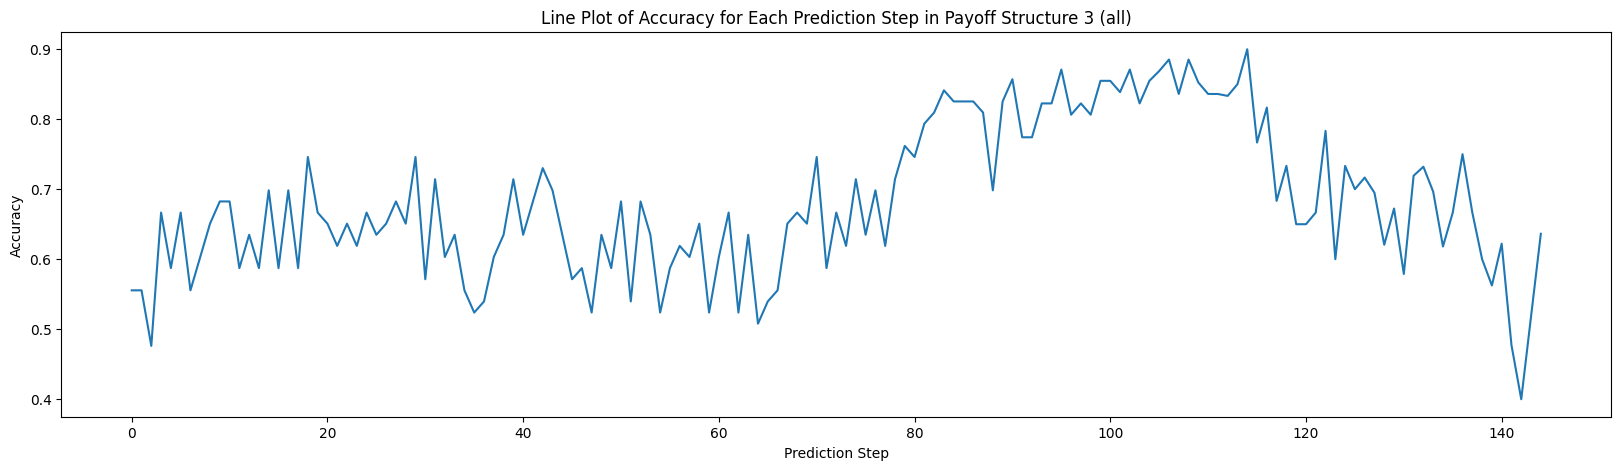

In [40]:
x_values = list(range(145))
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x_values, seq_3_accuracy)
ax.set_xlabel('Prediction Step')
ax.set_ylabel('Accuracy')
ax.set_title('Line Plot of Accuracy for Each Prediction Step in Payoff Structure 3 (all)')
# show the plot
plt.show()

In [41]:
unique_length = {}
for res in seq_3_total_result:
    if len(res) not in unique_length.keys():
        unique_length[len(res)] = 1
    else:
        unique_length[len(res)] += 1
print(unique_length)
invalid_result = []
for i, res in enumerate(seq_3_total_result):
    if len(res) < 130:
        invalid_result.append(i)
print(invalid_result)

{143: 8, 145: 11, 142: 9, 144: 16, 140: 3, 135: 1, 139: 2, 138: 1, 128: 1, 130: 1, 141: 1, 137: 1, 127: 1, 105: 1, 136: 2, 112: 1, 134: 1, 132: 1, 91: 1}
[21, 35, 36, 51, 58]


In [42]:
res_3_total_result_new = []
for i, res in enumerate(seq_3_total_result):
    if i not in invalid_result:
        res_3_total_result_new.append(res)
print(min([len(res) for res in res_3_total_result_new]))

130


In [43]:
seq_3_accuracy = calculate_accuracy(res_3_total_result_new)
print(seq_3_accuracy)

[0.5517241379310345, 0.5862068965517241, 0.5, 0.6551724137931034, 0.603448275862069, 0.6724137931034483, 0.5517241379310345, 0.6206896551724138, 0.6724137931034483, 0.7241379310344828, 0.7068965517241379, 0.603448275862069, 0.6551724137931034, 0.6206896551724138, 0.7068965517241379, 0.6206896551724138, 0.7068965517241379, 0.6206896551724138, 0.7758620689655172, 0.6724137931034483, 0.6724137931034483, 0.6379310344827587, 0.6724137931034483, 0.6379310344827587, 0.6551724137931034, 0.6724137931034483, 0.6551724137931034, 0.6896551724137931, 0.6896551724137931, 0.7413793103448276, 0.5862068965517241, 0.7068965517241379, 0.603448275862069, 0.6379310344827587, 0.5689655172413793, 0.5689655172413793, 0.5689655172413793, 0.6379310344827587, 0.6896551724137931, 0.7241379310344828, 0.6551724137931034, 0.6896551724137931, 0.7586206896551724, 0.7241379310344828, 0.6379310344827587, 0.5862068965517241, 0.5689655172413793, 0.5344827586206896, 0.6551724137931034, 0.603448275862069, 0.7241379310344828

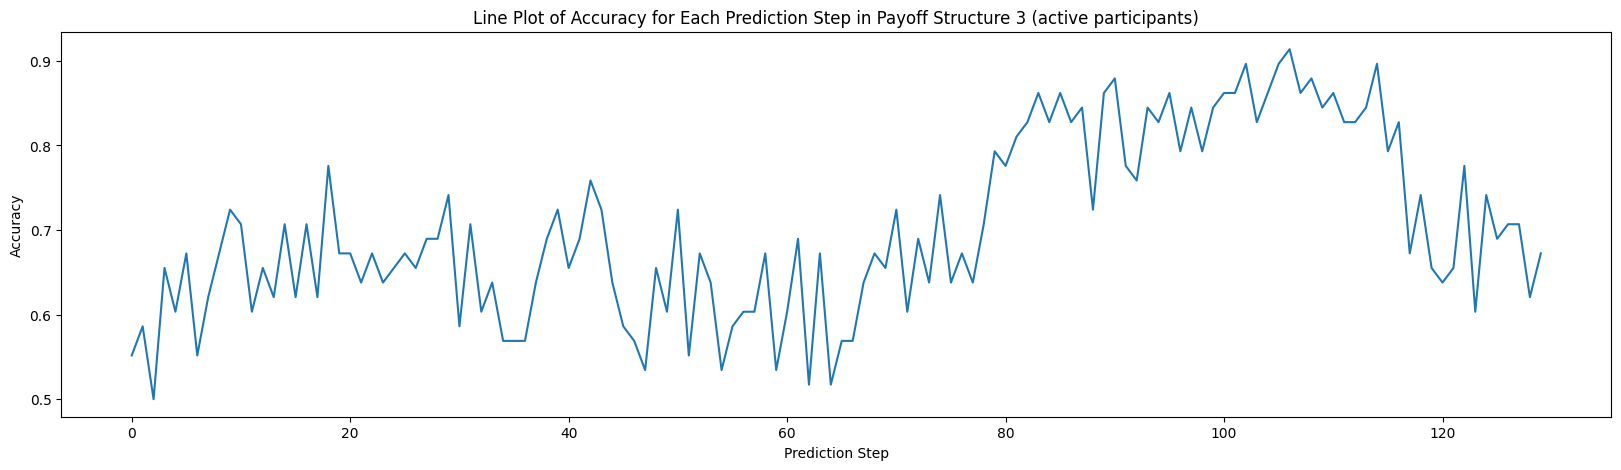

In [44]:
x_values = list(range(min([len(res) for res in res_3_total_result_new])))
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x_values, seq_3_accuracy)
ax.set_xlabel('Prediction Step')
ax.set_ylabel('Accuracy')
ax.set_title('Line Plot of Accuracy for Each Prediction Step in Payoff Structure 3 (active participants)')
# show the plot
plt.show()

## NN model for payoff structure 4

In [45]:
# Define the LSTM model
def create_model(units=64, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(4, 2), return_sequences=True))
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.99)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Generate some training data
X_train = seq_4_train_X
y_train = seq_4_train_y

# Train the model on the best set of parameters
model = create_model(units=64, learning_rate=0.001)
model.fit(X_train, y_train, epochs=300, batch_size=2048)

Epoch 1/300
19/19 [==============================] - 1s 15ms/step - loss: 1.2234 - accuracy: 0.4469
Epoch 2/300
19/19 [==============================] - 0s 17ms/step - loss: 1.1536 - accuracy: 0.5225
Epoch 3/300
19/19 [==============================] - 0s 17ms/step - loss: 1.1025 - accuracy: 0.5575
Epoch 4/300
19/19 [==============================] - 0s 18ms/step - loss: 1.0503 - accuracy: 0.6386
Epoch 5/300
19/19 [==============================] - 1s 27ms/step - loss: 0.9879 - accuracy: 0.6588
Epoch 6/300
19/19 [==============================] - 0s 22ms/step - loss: 0.9416 - accuracy: 0.6603
Epoch 7/300
19/19 [==============================] - 0s 21ms/step - loss: 0.9143 - accuracy: 0.6612
Epoch 8/300
19/19 [==============================] - 0s 23ms/step - loss: 0.8957 - accuracy: 0.6676
Epoch 9/300
19/19 [==============================] - 0s 19ms/step - loss: 0.8824 - accuracy: 0.6760
Epoch 10/300
19/19 [==============================] - 0s 20ms/step - loss: 0.8707 - accuracy: 0.6824

In [46]:
seq_4_total_result = []
seq_4_total_result_ = []

for id in seq_4_test_user_id:
    # select this id's data from payoff_2_test(DF)
    id_data = payoff_4_test[payoff_4_test['id'] == id]
    id_data = id_data[["choice", "reward"]]  # remove id column
    print(id_data.shape)
    seq_4_id_test = sliding_window(id_data)

    seq_id_test_X, seq_id_test_y = X_y_split_train_val(seq_4_id_test)

    X_test = seq_id_test_X
    y_pred = model.predict(X_test)
    y_true = seq_id_test_y

    y_pred_labels = list(np.argmax(y_pred, axis=1))
    y_true_labels = list(np.argmax(y_true, axis=1))

    id_result = []

    for i in range(len(y_pred_labels)):
        id_result.append(1 if y_pred_labels[i] == y_true_labels[i] else 0)
    
    seq_4_total_result.append(id_result)
    seq_4_total_result_.append(y_pred_labels)

print(seq_4_total_result_)

(145, 2)
5/5 [==============================] - 0s 1ms/step
(148, 2)
5/5 [==============================] - 0s 762us/step
(149, 2)
5/5 [==============================] - 0s 824us/step
(139, 2)
5/5 [==============================] - 0s 778us/step
(149, 2)
5/5 [==============================] - 0s 737us/step
(148, 2)
5/5 [==============================] - 0s 694us/step
(147, 2)
5/5 [==============================] - 0s 778us/step
(141, 2)
5/5 [==============================] - 0s 1ms/step
(149, 2)
5/5 [==============================] - 0s 923us/step
(145, 2)
5/5 [==============================] - 0s 816us/step
(145, 2)
5/5 [==============================] - 0s 899us/step
(145, 2)
5/5 [==============================] - 0s 768us/step
(146, 2)
5/5 [==============================] - 0s 1ms/step
(143, 2)
5/5 [==============================] - 0s 773us/step
(136, 2)
5/5 [==============================] - 0s 1ms/step
(146, 2)
5/5 [==============================] - 0s 1ms/step
(148, 2)
5/5 [====

In [47]:
seq_4_accuracy = []
for i in range(max(map(len, seq_4_total_result))):
    filtered_lists = [lst[i] for lst in seq_4_total_result if i < len(lst)]
    if filtered_lists:
        seq_4_accuracy.append(sum(filtered_lists) / len(filtered_lists))
    else:
        seq_4_accuracy.append(0)

print(seq_4_accuracy)

[0.5384615384615384, 0.46153846153846156, 0.49230769230769234, 0.6, 0.676923076923077, 0.6, 0.7076923076923077, 0.6923076923076923, 0.7076923076923077, 0.7076923076923077, 0.7384615384615385, 0.7230769230769231, 0.7384615384615385, 0.6615384615384615, 0.8, 0.7384615384615385, 0.7538461538461538, 0.6923076923076923, 0.7230769230769231, 0.6923076923076923, 0.7846153846153846, 0.6307692307692307, 0.8, 0.8, 0.7384615384615385, 0.8, 0.7538461538461538, 0.8153846153846154, 0.7230769230769231, 0.7846153846153846, 0.8153846153846154, 0.7846153846153846, 0.8, 0.7230769230769231, 0.7692307692307693, 0.7692307692307693, 0.7076923076923077, 0.7076923076923077, 0.8307692307692308, 0.7076923076923077, 0.676923076923077, 0.6923076923076923, 0.676923076923077, 0.6615384615384615, 0.7076923076923077, 0.6307692307692307, 0.7384615384615385, 0.7076923076923077, 0.7692307692307693, 0.676923076923077, 0.7846153846153846, 0.676923076923077, 0.6923076923076923, 0.6923076923076923, 0.7230769230769231, 0.69230

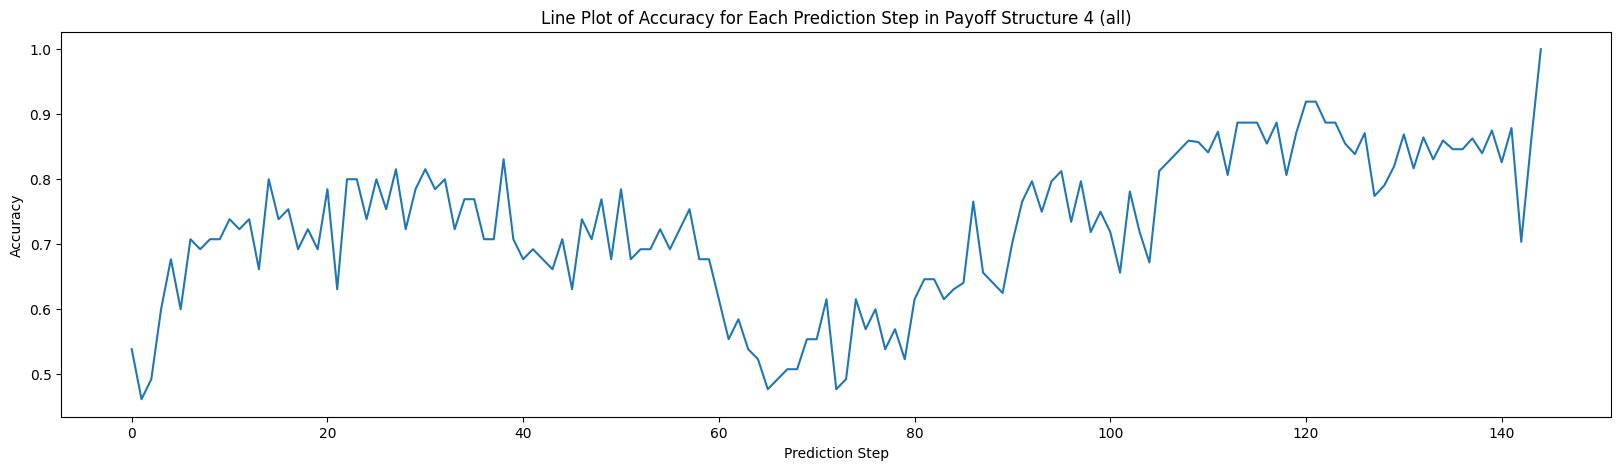

In [48]:
x_values = list(range(145))
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x_values, seq_4_accuracy)
ax.set_xlabel('Prediction Step')
ax.set_ylabel('Accuracy')
ax.set_title('Line Plot of Accuracy for Each Prediction Step in Payoff Structure 4 (all)')
# show the plot
plt.show()

In [49]:
unique_length = {}
for res in seq_4_total_result:
    if len(res) not in unique_length.keys():
        unique_length[len(res)] = 1
    else:
        unique_length[len(res)] += 1
print(unique_length)
invalid_result = []
for i, res in enumerate(seq_4_total_result):
    if len(res) < 130:
        invalid_result.append(i)
print(invalid_result)

{141: 13, 144: 15, 145: 6, 135: 5, 143: 6, 137: 1, 142: 6, 139: 2, 132: 1, 138: 1, 129: 1, 85: 1, 109: 1, 134: 2, 140: 2, 131: 1, 112: 1}
[25, 26, 30, 57]


In [50]:
res_4_total_result_new = []
for i, res in enumerate(seq_4_total_result):
    if i not in invalid_result:
        res_4_total_result_new.append(res)
print(min([len(res) for res in res_4_total_result_new]))

131


In [51]:
seq_4_accuracy = calculate_accuracy(res_4_total_result_new)
print(seq_4_accuracy)

[0.5245901639344263, 0.47540983606557374, 0.5081967213114754, 0.6065573770491803, 0.7049180327868853, 0.6229508196721312, 0.7213114754098361, 0.7049180327868853, 0.7049180327868853, 0.7213114754098361, 0.7540983606557377, 0.7213114754098361, 0.7377049180327869, 0.6557377049180327, 0.7868852459016393, 0.7540983606557377, 0.7540983606557377, 0.7049180327868853, 0.7377049180327869, 0.7049180327868853, 0.819672131147541, 0.639344262295082, 0.8032786885245902, 0.8032786885245902, 0.7377049180327869, 0.8360655737704918, 0.7868852459016393, 0.8360655737704918, 0.7377049180327869, 0.819672131147541, 0.8360655737704918, 0.819672131147541, 0.8032786885245902, 0.7540983606557377, 0.8032786885245902, 0.7868852459016393, 0.7213114754098361, 0.7213114754098361, 0.8524590163934426, 0.7213114754098361, 0.7049180327868853, 0.7377049180327869, 0.6885245901639344, 0.6885245901639344, 0.7540983606557377, 0.639344262295082, 0.7868852459016393, 0.7377049180327869, 0.819672131147541, 0.6721311475409836, 0.81

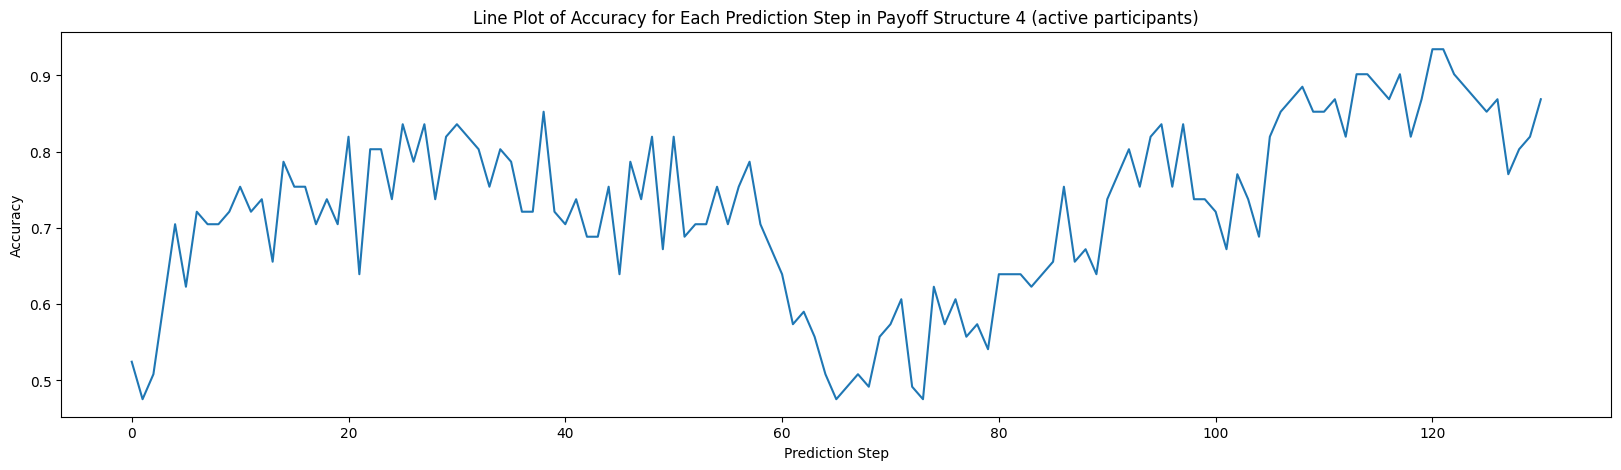

In [52]:
x_values = list(range(min([len(res) for res in res_4_total_result_new])))
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x_values, seq_4_accuracy)
ax.set_xlabel('Prediction Step')
ax.set_ylabel('Accuracy')
ax.set_title('Line Plot of Accuracy for Each Prediction Step in Payoff Structure 4 (active participants)')
# show the plot
plt.show()